In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

from torch import optim
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os
from torchvision import utils


from torch import nn
from torch import Tensor
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary
import numpy as np
import time
import copy
import random
from tqdm.notebook import tqdm
import math

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [29]:
# pip install einops

In [30]:
path2data = 'cifar100'
if not os.path.exists(path2data):
    os.mkdir(path2data)

# load dataset
# 데이터셋 로드 (학습용)
train_ds = datasets.CIFAR100(path2data, train=True, download=True, transform=transforms.ToTensor())

# 데이터셋 로드 (검증용)
val_ds = datasets.CIFAR100(path2data, train=False, download=True, transform=transforms.ToTensor())

print(len(train_ds))  # 학습용 데이터셋 크기 출력
print(len(val_ds))  # 검증용 데이터셋 크기 출력

Files already downloaded and verified
Files already downloaded and verified
50000
10000


In [31]:
# define transformation
transformation = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize(224)
])

# apply transformation to dataset
train_ds.transform = transformation
val_ds.transform = transformation

# make dataloade
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=64, shuffle=True)

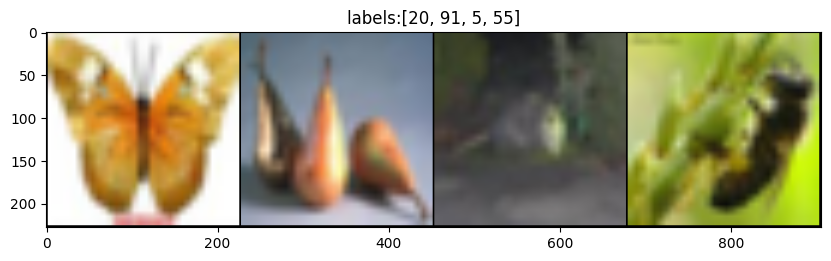

In [32]:
# check sample images
def show(img, y=None):
    npimg = img.numpy()
    npimg_tr = np.transpose(npimg, (1, 2, 0))
    plt.imshow(npimg_tr)

    if y is not None:
        plt.title('labels:' + str(y))

np.random.seed(10)
torch.manual_seed(0)

grid_size=4
train_ind = np.random.randint(0, len(train_ds), grid_size)
val_ind = np.random.randint(0, len(val_ds), grid_size)


x_grid = [train_ds[i][0] for i in train_ind]
y_grid = [val_ds[i][1] for i in val_ind]

x_grid = utils.make_grid(x_grid, nrow=grid_size, padding=2)
plt.figure(figsize=(10,10))
show(x_grid, y_grid)

# PatchEmbedding

In [33]:
# To handle 2D images, reshape the image into a sequence of flattened 2D patches.
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=3, patch_size=16, emb_size=768, img_size=224):
        super().__init__()
        self.patch_size = patch_size

        # # Method 1: Flatten and FC layer
        # self.projection = nn.Sequential(
        #     Rearrange('b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size),
        #     nn.Linear(path_size * patch_size * in_channels, emb_size)
        # )

        # Method 2: Conv
        self.projection = nn.Sequential(
            # using a conv layer instead of a linear one -> performance gains
            nn.Conv2d(in_channels, emb_size, patch_size, stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e')
        )

        self.cls_token = nn.Parameter(torch.randn(1,1,emb_size))
        self.positions = nn.Parameter(torch.randn((img_size // patch_size) ** 2 + 1, emb_size))

    def forward(self, x):
        b = x.shape[0]
        x = self.projection(x)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        # prepend the cls token to the input
        x = torch.cat([cls_tokens, x], dim=1)
        # add position embedding to prejected patches
        x += self.positions
        return x

In [34]:
# Check PatchEmbedding
x = torch.randn(16, 3, 224, 224).to(device)
patch_embedding = PatchEmbedding().to(device)
patch_output = patch_embedding(x)
print('[batch, 1+num of patches, emb_size] = ', patch_output.shape)

[batch, 1+num of patches, emb_size] =  torch.Size([16, 197, 768])


# MultiHeadAttention

In [35]:
# MultiHeadAttention
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size=768, num_heads=8, dropout=0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.keys = nn.Linear(emb_size, emb_size)
        self.queries = nn.Linear(emb_size, emb_size)
        self.values = nn.Linear(emb_size, emb_size)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)

    def forward(self, x, mask=None):
        # split keys, queries and values in num_heads
        queries = rearrange(self.queries(x), 'b n (h d) -> b h n d', h=self.num_heads) # b, 197, 728 -> b, 8, 197, 91
        keys = rearrange(self.keys(x), 'b n (h d) -> b h n d', h=self.num_heads)
        values = rearrange(self.values(x), 'b n (h d) -> b h n d', h=self.num_heads)
        # sum up over the last axis, b,h,197,197
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # batch, num_head, query_len, key_len

        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)

        scaling = self.emb_size ** (1/2)
        att = F.softmax(energy, dim=-1) / scaling
        att = self.att_drop(att)
        # sum up over the third axis
        out = torch.einsum('bhal, bhlv -> bhav', att, values) # 197x91
        out = rearrange(out, 'b h n d -> b n (h d)')
        out = self.projection(out)
        return out

In [36]:
# Check MultiHeadAttention
MHA = MultiHeadAttention().to(device)
MHA_output = MHA(patch_output)
print(MHA_output.shape)


torch.Size([16, 197, 768])


# Residual

In [37]:
# perform the residual addition.
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

# FeedForwardBlock

In [38]:
# Subclassing nn.Sequential to avoid writing the forward method.
class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size, expansion=4, drop_p=0.):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )


In [39]:
# check
x = torch.randn(16,1,128).to(device)
model = FeedForwardBlock(128).to(device)
output = model(x)
print(output.shape)

torch.Size([16, 1, 128])


# TransformerEncoderBlock

In [40]:
# Now create the Transformer Encoder Block
class TransformerEncoderBlock(nn.Sequential):
    def __init__(self, emb_size=768, drop_p=0., forward_expansion=4, forward_drop_p=0., **kwargs):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, **kwargs),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            ))
        )

In [41]:
# Check TransformerEncoderBlock
model = TransformerEncoderBlock().to(device)
output = model(patch_output).to(device)
print(output.shape)

torch.Size([16, 197, 768])


# TransformerEncoder

In [42]:
# TransformerEncoder consists of L blocks of TransformerBlock
class TransformerEncoder(nn.Sequential):
    def __init__(self, depth=12, **kwargs):
        super().__init__(*[TransformerEncoderBlock(**kwargs) for _ in range(depth)])

In [43]:
# Check TransformerEncoder
model = TransformerEncoder().to(device)
output = model(patch_output)
print(output.shape)


torch.Size([16, 197, 768])


# ClassificationHead

In [44]:
# define ClassificationHead which gives the class probability
class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size=768, n_classes = 10):
        super().__init__(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size),
            nn.Linear(emb_size, n_classes))

In [45]:
# check
x = torch.randn(16, 1, 768).to(device)
model = ClassificationHead().to(device)
output = model(x)
print(output.shape)

torch.Size([16, 10])


# ViT

In [46]:
# Define the ViT architecture
class ViT(nn.Sequential):
    def __init__(self, in_channels=3, patch_size=16, emb_size=768, img_size=224, depth=12, n_classes=10, **kwargs):
        super().__init__(
            PatchEmbedding(in_channels, patch_size, emb_size, img_size),
            TransformerEncoder(depth, emb_size=emb_size, **kwargs),
            ClassificationHead(emb_size, n_classes)
        )

In [47]:
# Check
x = torch.randn(16,3,224,224).to(device)
model = ViT().to(device)
output = model(x)
print(output.shape)

torch.Size([16, 10])


In [48]:
model = ViT().to(device)
summary(model, (3,224,224), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
         Rearrange-2             [-1, 196, 768]               0
    PatchEmbedding-3             [-1, 197, 768]               0
         LayerNorm-4             [-1, 197, 768]           1,536
            Linear-5             [-1, 197, 768]         590,592
            Linear-6             [-1, 197, 768]         590,592
            Linear-7             [-1, 197, 768]         590,592
           Dropout-8          [-1, 8, 197, 197]               0
            Linear-9             [-1, 197, 768]         590,592
MultiHeadAttention-10             [-1, 197, 768]               0
          Dropout-11             [-1, 197, 768]               0
      ResidualAdd-12             [-1, 197, 768]               0
        LayerNorm-13             [-1, 197, 768]           1,536
           Linear-14            [-1, 1